# RSA Connectivity Matrices


## 1. Imports
Import core libraries for file handling, data manipulation, visualization, and project‑specific utilities. Configure global plotting styles for consistency.


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from convergence.figures import plot_cbar_set, setup_matplotlib_fonts
from convergence.network import reorder_matrix_spectral_simplified

setup_matplotlib_fonts()

## 2. Data Paths
Define filesystem locations for HCP metadata, RSA result files, and the output directory for figures.


### 2.1 Input Files
- `hcp.csv`: Glasser et al. (2016) HCP atlas ROIs information  
- `rsa_pvalues_subject_language_vision.parquet`: Permutation p‑values for RSA tests  
- `rsa_subject_subject_alignment_shift_1_joined.parquet`: Intersubject RSA (joined hemispheres, shifted)  
- `rsa_subject_subject_alignment_shift_1_separated.parquet`: Intersubject RSA (separate hemispheres, shifted)  
- `rsa_subject_subject_alignment_joined_0.parquet`: Intersubject RSA (joined hemispheres, unshifted)


In [2]:
# Required filenames for the figures
data_folder = Path("../derivatives")
hcp_filename = data_folder / "metadata" / "hcp.csv"
nsd_folder = data_folder / "nsd"
intersubject_shift1_joined_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"
)
intersubject_shift1_separated_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_separated.parquet"
)
intersubject_shift0_joined_filename = (
    nsd_folder / "rsa_subject_subject_alignment_joined_0.parquet"
)

# Output folder for figures
figure_folder = Path("../figures")
output = figure_folder / "04_rsa_connectivity"
output.mkdir(exist_ok=True, parents=True)

### 2.2 Input Validation
Verify that all required files and directories exist, raising an assertion error if any path is missing.


In [3]:
for filename in (
    data_folder,
    hcp_filename,
    intersubject_shift1_joined_filename,
    intersubject_shift1_separated_filename,
    intersubject_shift0_joined_filename,
):
    assert filename.exists(), f"File {filename} does not exist. Please check the path."

## 3. Utility Functions
Define helper routines:
- `compute_connectivity_matrix`: Load RSA results, apply a row/column filter, compute group‐mean similarities, and pivot to an ROI×ROI matrix with human‐readable ROI labels.  
- `plot_connectivity_matrix`: Render a centered, symmetric heatmap of the connectivity matrix with customizable colormap and limits.


In [4]:
def compute_connectivity_matrix(filename:Path, query: str, hcp_filename: Path) -> pd.DataFrame:
    """Utility function to aggregate group-wise connectivity matrices and return a pivoted 
    DataFrame with n_rois x n_rois"""

    # Load filename with similarity
    df_cross_subject = pd.read_parquet(filename)
    # Filter specific rois
    df_cross_subject = df_cross_subject.query(query) 
    # Group-wise mean
    df_cross_subject = df_cross_subject.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()

    hcp = pd.read_csv(hcp_filename)[["name", "roi"]]
    df_cross_subject = df_cross_subject.merge(
        hcp.rename(columns={"roi": "roi_x", "name": "name_x"}), on="roi_x"
    )
    df_cross_subject = df_cross_subject.merge(
        hcp.rename(columns={"roi": "roi_y", "name": "name_y"}), on="roi_y"
    )
    df_cross_subject_pivotted = df_cross_subject.pivot(
        index="name_x", columns="name_y", values="similarity"
    )
    return df_cross_subject_pivotted

def plot_connectivity_matrix(df, vmax=0.2, figsize=(6, 6), cmap="RdBu_r", ax=None, **kwargs):
    """Utility function to plot a connectivity matrix using seaborn heatmap"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = None
    sns.heatmap(
        data=df,
        cmap=cmap,
        center=0,
        vmin=-vmax,
        vmax=vmax,
        xticklabels=df.columns,
        yticklabels=df.index,
        square=True,
        ax=ax,
        cbar=False,
        **kwargs,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax


## 4. ROI Selection & Ordering
Select the top 30 ROIs by within‑subject alignment consistency and specify a manual ordering—derived from hierarchical clustering plus manual tweaks—to group functionally similar regions together.


In [5]:
order = ['V1', 'V2', 'V3', 'V4', 
         'V8', 'V3A', 'V3B', 'V3CD', 'VVC', 
         'VMV3', 'VMV2', 'VMV1', 
         'PHA1', 'PHA2', 'PHA3',
         'IP0', 'PGp', 'DVT', 'LO3', 'LO2', 'PIT', 'LO1',
         'FFC', 'PH',
         'TPOJ3', 'V4t', 'FST', 'MST', 'MT', 'TPOJ2']

Sanity check. Check that the predefined order matches the top 30 ROIs by within‑subject alignment consistency. If not, raise an assertion error.

In [6]:
# Load within-subject connectivity
top = 30
df_within_subject = pd.read_parquet(intersubject_shift1_joined_filename)
df_within_subject = df_within_subject.query("roi_x == roi_y and subject_i == subject_j")
df_within_subject = df_within_subject.groupby("roi_x").similarity.mean().reset_index()
df_within_subject = df_within_subject.nlargest(top, "similarity") # Get top
top_rois = df_within_subject.roi_x.tolist()
hcp = pd.read_csv(hcp_filename)[["name", "roi"]]
top_rois = hcp.query("roi in @top_rois").name.tolist()

# Check order and top rois have the exactly same rois
assert set(order) == set(top_rois), "Order and top rois do not match."

## 5. Intersubject Connectivity
Plot the group‐average intersubject connectivity (different subjects, shifted repetitions, joined hemispheres) over the top 30 ROIs.


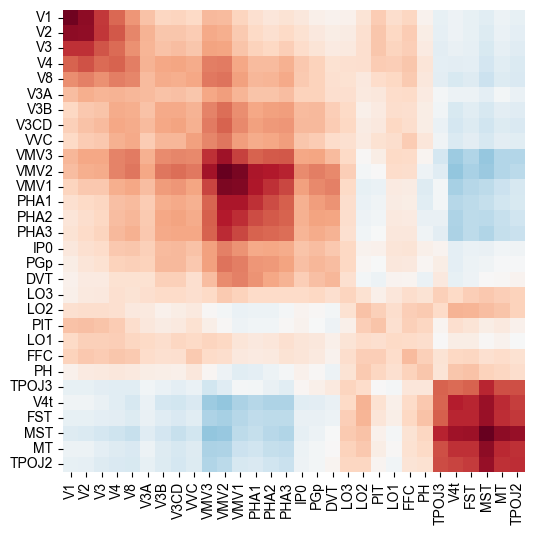

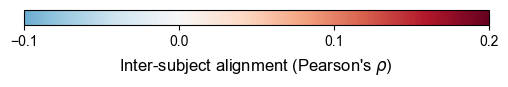

In [7]:
query = "subject_i != subject_j"
filename = intersubject_shift1_joined_filename
vmax = 0.2
output_file = output / f"01_connectivity_top_30_intersubject_shift1_{vmax:.2f}.pdf"

# Get connectivity matrix
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30 = df.loc[order, order]

# Plot connectivity matrix
fig, ax = plot_connectivity_matrix(df=df_top30, vmax=vmax)
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Plot colorbars
title="Inter-subject alignment (Pearson's $\\rho$)"
output_file = output / f"01_colobar_intersubject_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.1)

## 6. Within‑Subject Connectivity
Plot the group‐average within‑subject connectivity (same subject, shifted repetitions, joined hemispheres) for the top 30 ROIs.


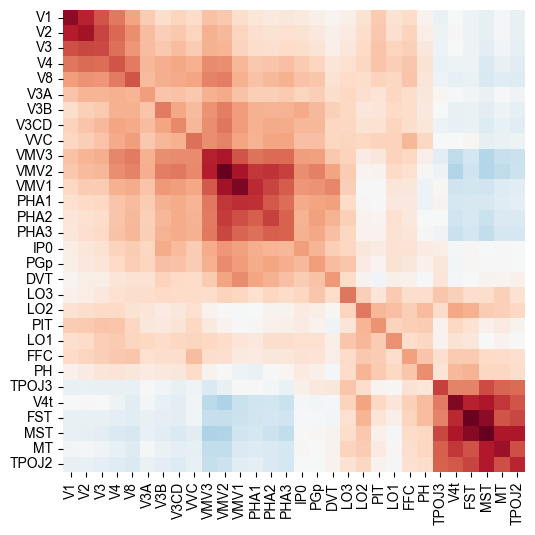

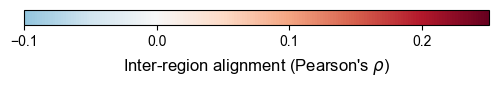

In [8]:
query = "subject_i == subject_j" # Only pairs
filename = intersubject_shift1_joined_filename
vmax = 0.25
output_file = output / f"02_connectivity_top_30_withinsubject_shift1_{vmax:.2f}.pdf"

# Get connectivity matrix
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30 = df.loc[order, order]

# Plot connectivity matrix
fig, ax = plot_connectivity_matrix(df=df_top30, vmax=vmax)
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Plot colorbars
title="Inter-region alignment (Pearson's $\\rho$)"
output_file = output / f"02_colobar_withingsubject_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.1)

## 7. Hemisphere‑Specific Within‑Subject Connectivity
Visualize within‑subject connectivity separately for left and right hemispheres (same subject, shifted repetitions) over the top 30 ROIs.


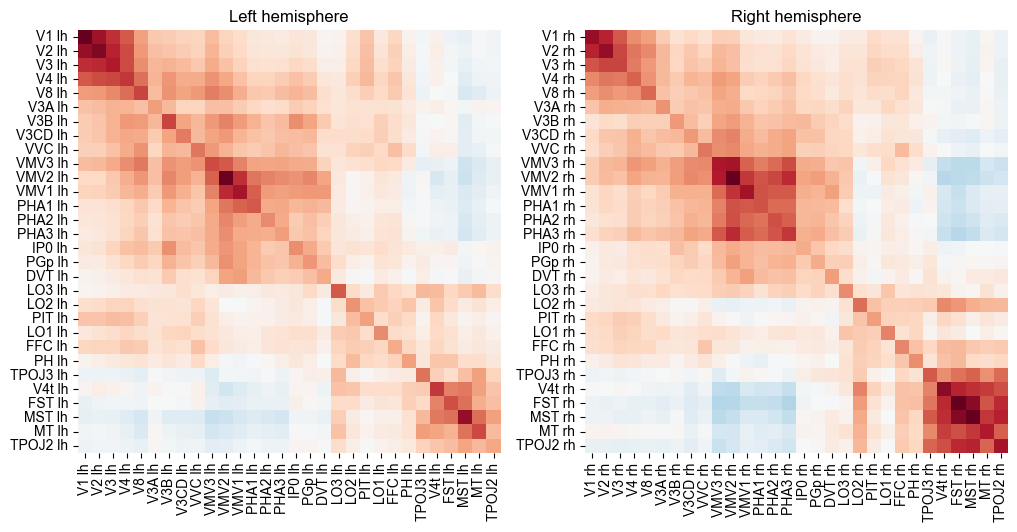

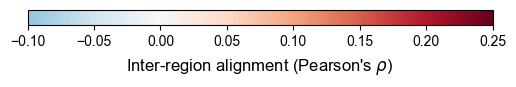

In [9]:
# Use filename with 360 x 360 comparisons (separated)
filename = intersubject_shift1_separated_filename
vmax = 0.25
fig, (ax_lh, ax_rh) = plt.subplots(1, 2, figsize=(12, 6))
 
# Left hemisphere (get 180 x 180 comparisons of lh)
query = "subject_i == subject_j and roi_x <= 180 and roi_y <= 180" 
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30 = df.loc[order, order]
df_top30.columns =  [c + " lh" for c in df_top30.columns]
df_top30.index = [c + " lh" for c in df_top30.index]
plot_connectivity_matrix(df=df_top30, vmax=vmax, ax=ax_lh)
ax_lh.set_title("Left hemisphere")

#Right hemisphere (get 180 x 180 comparisons of rh)
query = "subject_i == subject_j and roi_x > 180 and roi_y > 180" 
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30 = df.loc[order, order]
df_top30.columns =  [c + " rh" for c in df_top30.columns]
df_top30.index = [c + " rh" for c in df_top30.index]
plot_connectivity_matrix(df=df_top30, vmax=vmax, ax=ax_rh)
ax_rh.set_title("Right hemisphere")

# Save plot
output_file = output / f"03_connectivity_top_30_withinsubject_shift1_{vmax:.2f}_hemispheres.pdf"
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Plot colorbars
title="Inter-region alignment (Pearson's $\\rho$)"
output_file = output / f"03_colobar_withingsubject_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.1, locator=0.05)

## 8. Within vs. Intersubject Comparison
Compare within‑subject and intersubject connectivity matrices side by side (joined hemispheres, shifted repetitions) for the top 30 ROIs.


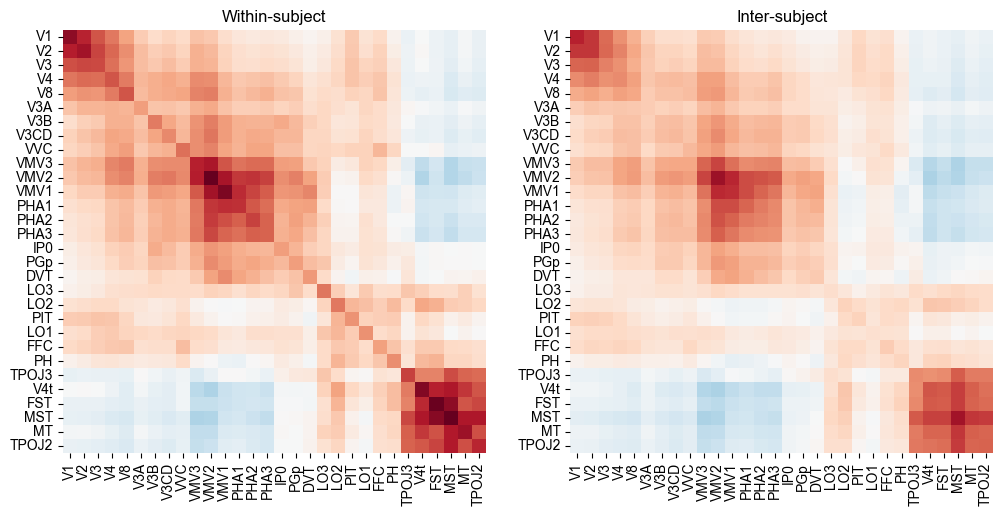

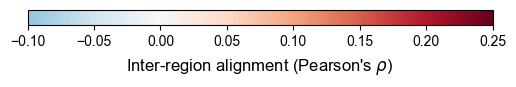

In [10]:
# Use filename with 360 x 360 comparisons (separated)
filename = intersubject_shift1_joined_filename
vmax = 0.25
fig, (ax_lh, ax_rh) = plt.subplots(1, 2, figsize=(12, 6))
 
# Left hemisphere (get 180 x 180 comparisons of lh)
query = "subject_i == subject_j" 
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30 = df.loc[order, order]
plot_connectivity_matrix(df=df_top30, vmax=vmax, ax=ax_lh)
ax_lh.set_title("Within-subject")

#Right hemisphere (get 180 x 180 comparisons of rh)
query = "subject_i != subject_j" 
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30 = df.loc[order, order]
plot_connectivity_matrix(df=df_top30, vmax=vmax, ax=ax_rh)
ax_rh.set_title("Inter-subject")

# Save plot
output_file = output / f"04_connectivity_top_30_shift1_{vmax:.2f}_within_vs_inter.pdf"
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Plot colorbars
title="Inter-region alignment (Pearson's $\\rho$)"
output_file = output / f"04_colobar_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.1, locator=0.05)

## 9. Shifted vs. Unshifted Intersubject Comparison
Compare intersubject connectivity with shifted vs. unshifted repetitions (joined hemispheres) side by side for the top 30 ROIs.


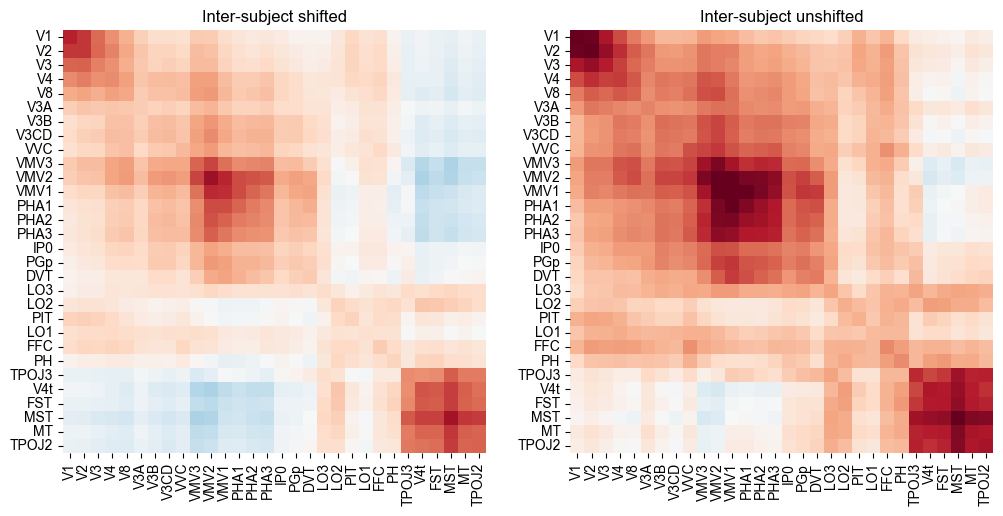

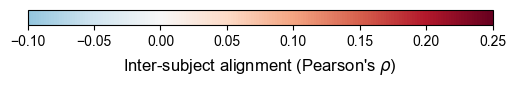

In [11]:
# Use filename with 360 x 360 comparisons (separated)
query = "subject_i != subject_j" 
vmax = 0.25
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Inter-subject shifted
filename = intersubject_shift1_joined_filename
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30_1 = df.loc[order, order]
plot_connectivity_matrix(df=df_top30_1, vmax=vmax, ax=ax1)
ax1.set_title("Inter-subject shifted")

# Inter-subject unshifted
filename = intersubject_shift0_joined_filename
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
df_top30_2 = df.loc[order, order]
plot_connectivity_matrix(df=df_top30_2, vmax=vmax, ax=ax2)
ax2.set_title("Inter-subject unshifted")

# Save plot
output_file = output / f"05_connectivity_top_30_shift1_{vmax:.2f}_shifted_vs_unshifted.pdf"
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Plot colorbars
title="Inter-subject alignment (Pearson's $\\rho$)"
output_file = output / f"05_colobar_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.1, locator=0.05)

## 10. Whole‑Brain Connectivity (Top 100 ROIs)
Display within‑subject connectivity for the top 100 ROIs (by absolute mean similarity), automatically reordered via a spectral clustering algorithm for clearer modular structure.


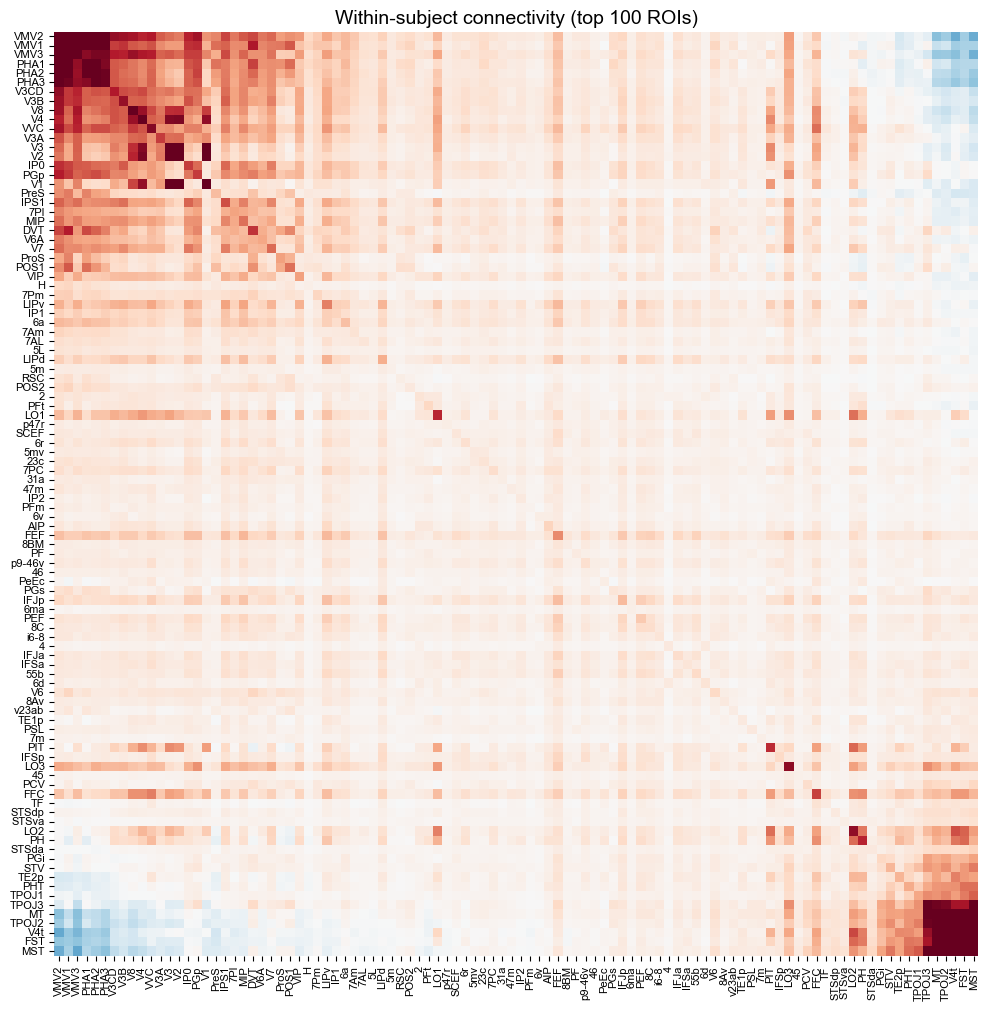

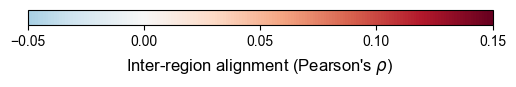

In [12]:
query = "subject_i == subject_j" # Only pairs
filename = intersubject_shift1_joined_filename
vmax = 0.15
n_nodes = 100 # Number of nodes to plot
output_file = output / f"06_connectivity_top_30_withinsubject_shift1_{vmax:.2f}_{n_nodes}_rois.pdf"

# Get connectivity matrix
df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
top_areas = df.abs().max().nlargest(n_nodes).index.tolist()
df = df.loc[top_areas, top_areas]
# Automatically reorder the matrix using spectral reordering
df_reorder = reorder_matrix_spectral_simplified(df)


fig, ax = plot_connectivity_matrix(df=df_reorder, vmax=vmax, figsize=(12, 12))
# Make smaller xtick lables
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=8)
ax.set_title(f"Within-subject connectivity (top {n_nodes} ROIs)", fontsize=14)
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Plot colorbars
title="Inter-region alignment (Pearson's $\\rho$)"
output_file = output / f"06_colobar_withingsubject_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.05, locator=0.05)

## 11. Subject‑Wise Within‑Subject Connectivity
Render individual within‑subject connectivity matrices for each subject (1–8) plus the group average, arranged in a 3×3 grid for direct comparison.


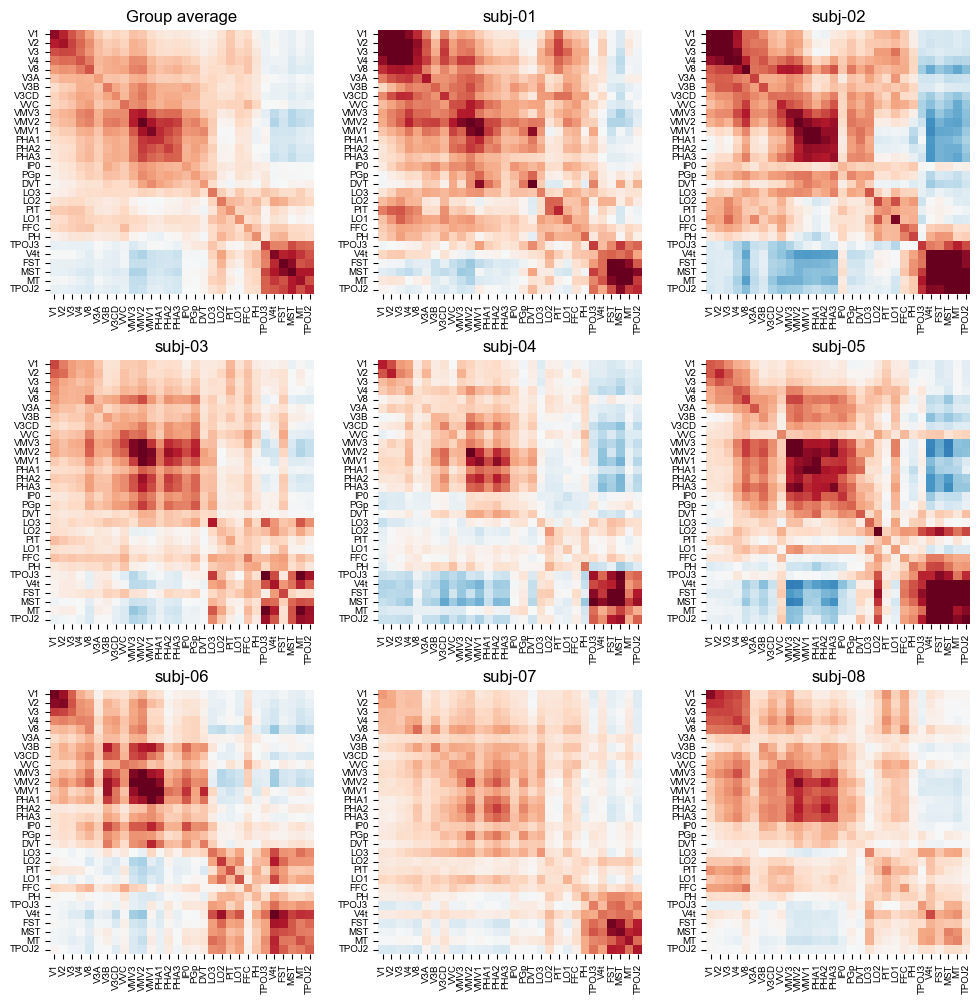

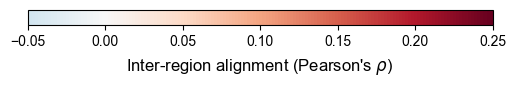

In [13]:
filename = intersubject_shift1_joined_filename
vmax = 0.25
output_file = output / f"07_connectivity_top_30_withinsubject_shift1_{vmax:.2f}_subjects.pdf"
rois = order

# rois = df_reorder.columns.tolist() # Uncomment to get all rois

fig, axes = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={"hspace": 0.25})

for n_subject, ax in enumerate(axes.flat):
    
    if n_subject == 0:
        query = "subject_i == subject_j"
        ax.set_title(f"Group average")
    else:
        query = "(subject_i == subject_j) and subject_i == @n_subject"
        ax.set_title(f"subj-0{n_subject}")

    df = compute_connectivity_matrix(filename=filename, query=query, hcp_filename=hcp_filename)
    df = df.loc[rois, rois]
    plot_connectivity_matrix(df=df, vmax=vmax, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=7)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=7)
    
fig.savefig(output_file, bbox_inches="tight", transparent=True)

# Plot colorbars
title="Inter-region alignment (Pearson's $\\rho$)"
output_file = output / f"07_colobar_withingsubject_{vmax:.2f}.pdf"
plot_cbar_set(title=title, filename=output_file, vmax=vmax, vmin=-0.05, locator=0.05)